<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project4/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import urllib.request
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datapath = os.path.join("datasets", "customer", "")
os.makedirs(datapath, exist_ok=True)

# Dataset is already split into test and train data
file_path_train = "https://raw.githubusercontent.com/robd123/AML/main/Project4/CustomerTrain.csv"
file_path_test = "https://raw.githubusercontent.com/robd123/AML/main/Project4/CustomerTest.csv"

urllib.request.urlretrieve(file_path_train, datapath + "CustomerTrain.csv")
train_data = pd.read_csv(datapath + "CustomerTrain.csv", thousands=',')

urllib.request.urlretrieve(file_path_test, datapath + "CustomerTest.csv")
test_data = pd.read_csv(datapath + "CustomerTest.csv", thousands=',')

# Combine test and train data so I have a larger dataset, and only need to run my pipeline once
# Will split again using sklearn before prediction
customer_data = pd.concat([train_data, test_data])
print(customer_data.shape)
print(customer_data.head())

(10695, 11)
       ID  Gender Ever_Married  ...  Family_Size  Var_1 Segmentation
0  462809    Male           No  ...          4.0  Cat_4            D
1  462643  Female          Yes  ...          3.0  Cat_4            A
2  466315  Female          Yes  ...          1.0  Cat_6            B
3  461735    Male          Yes  ...          2.0  Cat_6            B
4  462669  Female          Yes  ...          6.0  Cat_6            A

[5 rows x 11 columns]


**Look for Missing Data**

In [11]:
print(customer_data.isnull().sum())

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64


**Determine Data Types**

In [12]:
print(customer_data.dtypes)

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object


**Convert all Object Types to Category Types**

In [13]:
customer_data['Gender'] = pd.Categorical(customer_data["Gender"])
customer_data['Ever_Married'] = pd.Categorical(customer_data["Ever_Married"])
customer_data['Graduated'] = pd.Categorical(customer_data["Graduated"])
customer_data['Profession'] = pd.Categorical(customer_data["Profession"])
customer_data['Spending_Score'] = pd.Categorical(customer_data["Spending_Score"])
customer_data['Var_1'] = pd.Categorical(customer_data["Var_1"])
customer_data['Segmentation'] = pd.Categorical(customer_data["Segmentation"])
print(customer_data.dtypes)

ID                    int64
Gender             category
Ever_Married       category
Age                   int64
Graduated          category
Profession         category
Work_Experience     float64
Spending_Score     category
Family_Size         float64
Var_1              category
Segmentation       category
dtype: object


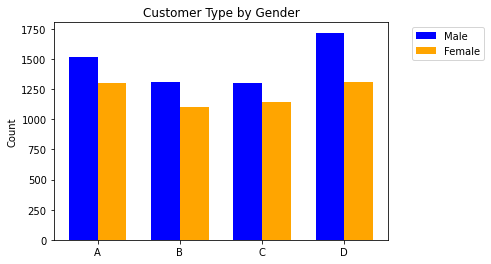

In [31]:
male = customer_data[customer_data.Gender == 'Male']
female = customer_data[customer_data.Gender == 'Female']
count_male_A = len(male[male.Segmentation == 'A'])
count_male_B = len(male[male.Segmentation == 'B'])
count_male_C = len(male[male.Segmentation == 'C'])
count_male_D = len(male[male.Segmentation == 'D'])
count_female_A = len(female[female.Segmentation == 'A'])
count_female_B = len(female[female.Segmentation == 'B'])
count_female_C = len(female[female.Segmentation == 'C'])
count_female_D = len(female[female.Segmentation == 'D'])

male_count = [count_male_A, count_male_B, count_male_C, count_male_D]
female_count = [count_female_A, count_female_B, count_female_C, count_female_D]

labels = ['A', 'B', 'C', 'D']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male_count, width, label='Male', color='blue')
rects2 = ax.bar(x + width/2, female_count, width, label='Female', color='orange')

ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Customer Type by Gender')
plt.show()